In [10]:
import numpy
import math
import csv
import time
import matplotlib.pyplot as plt
import ast
from scipy import stats
import pandas as pd

In [11]:
def generateSequence(sequence, domain, value, operator, probability, fr, to):
    if operator == 'eq':
        prob = [(1.0 - probability) / (len(domain) - 1) for i in domain]
        prob[domain.index(value)] = probability
        seq = list(sequence)
        for i in range(fr, to):
            seq[i] = numpy.random.choice(domain, p = prob)

        return seq

In [13]:
def plotSequence(axarr, seq, domain, attrName, curr_state):
    N = 1
    colors = [numpy.random.rand(3,1) for i in domain]
    ind = numpy.arange(N)    # the x locations for the groups

    p = [0 for i in domain]
    for i in range(0, len(seq)):
        for j in range(0, len(domain)):
            if seq[i] == domain[j]:
                p[j] = axarr.barh(ind, 1, left=i, color=colors[j] )

    axarr.set_xlabel('State nr')
    axarr.set_ylabel(str(attrName))
    axarr.set_yticks([])
    axarr.set_yticklabels(['Attr_1'])

    axarr.set_xticklabels(numpy.arange(-curr_state, len(seq)-curr_state+1, 10),minor=False)
    axarr.set_xticks(numpy.arange(0, len(seq)+1, 10),minor=False)
    axarr.legend((p), (domain))

In [14]:
def saveToCsv(listOfConfigs, sequences):
    timestr = time.strftime("%Y_%m_%d-%H:%M:%S")
    with open('sequence_'+timestr+'.csv','wb') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow([config['attr_name'] for config in listOfConfigs])
        for i in range(len(sequences[0])):
            writer.writerow([seq[i] for seq in sequences])

In [131]:
def seq_stats(config, seq):
    config_values = config['value']
    domain = ast.literal_eval(config_values[0]['domain'])
    
    for config_val in config_values:
        value = ast.literal_eval(config_val['value'])
        probability = float(config_val['probability'])
        
        fr = abs(int(float(config_val['from'])))
        if config_val['to'] != '0':
            to = abs(int(float(config_val['to'])))
        else:
            to = 0

        counter = seq[curr_state-fr:curr_state-to].count(value)
        
        print "Value:", value
        print "< -",fr, ",-",to," >"
        print "Should be about: ", len(seq[curr_state-fr:curr_state-to])*probability, " (", probability*100, "%)"
        print "Is: ", counter, " (", (counter/(len(seq[curr_state-fr:curr_state-to])*1.0))*100.0, "%)"
        print 
        
    

Parameters

In [132]:
plt.rcParams['figure.figsize'] = 18, 6

past_states = 1.5
future_states = 1.5

plot = True
save = False
random = True

Get configurations from config file and group them by attribute name.

In [133]:
with open("config") as f:
    lines = f.readlines()

config_list = []
for line in lines:
    line = line.replace(" ", "").replace("\n", "")
    config = {}
    for elem in line.split(';'):
        elem = elem.split('=')
        config[elem[0]] = elem[1]
    config_list.append(config)

grouped_config_list = []
for config in config_list:
    key = config['attr'].replace("'","")
    if not any(key in d['attr_name'] for d in grouped_config_list):
        attr_dict = {}
        values_list = []
        values_list.append(config)
        attr_dict['attr_name'] = key
        attr_dict['value'] = values_list
        grouped_config_list.append(attr_dict)
    else:
        attr_dict = [d for d in grouped_config_list if d['attr_name'] == key][0]
        attr_dict['value'].append(config)

# for conf in grouped_config_list:
#     for key, value in conf.items():
#         print key,": ", value if key == 'attr_name' else ' '
#         if key != 'attr_name':
#             for v in value:
#                 print "\t", v
#     print

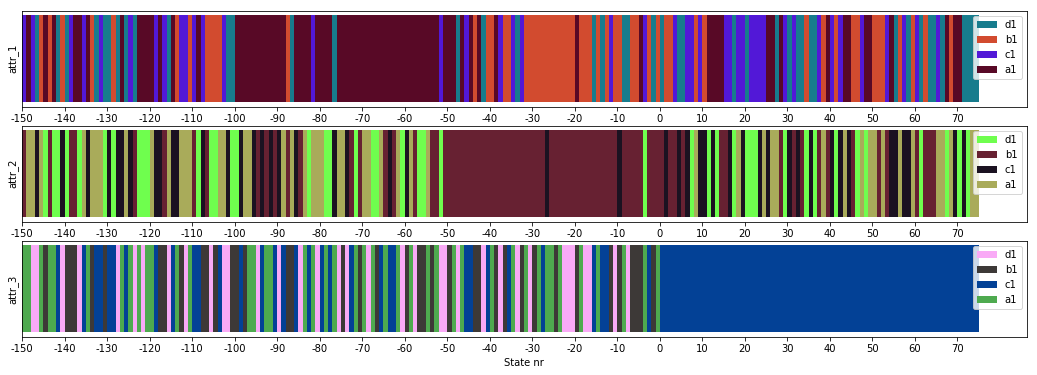

Value: a1
< - 100 ,- 50  >
Should be about:  45.0  ( 90.0 %)
Is:  45  ( 90.0 %)

Value: b1
< - 30 ,- 0  >
Should be about:  24.0  ( 80.0 %)
Is:  21  ( 70.0 %)

Value: b1
< - 50 ,- 0  >
Should be about:  45.0  ( 90.0 %)
Is:  47  ( 94.0 %)



In [134]:
curr_state = int(max([abs(int(float(config_list[i]['from']))) for i in range(len(config_list)) if 'from' in config_list[i]])*past_states)
last_state = int(curr_state*future_states)
seqs = []
number_of_configs = len(grouped_config_list)
f, axarr = plt.subplots(number_of_configs)

for counter, config in enumerate(grouped_config_list):
    config_values = config['value']
    init_value = ast.literal_eval(config_values[0]['domain'])[0]
    domain = ast.literal_eval(config_values[0]['domain'])
    operator = 'eq'
    
    if random:
        seq = [numpy.random.choice(ast.literal_eval(config_values[0]['domain'])) for k in range(0, last_state)]
    else:
        seq = [init_value for k in range(0, last_state)]
    
    for config_val in config_values:
        value = ast.literal_eval(config_val['value'])
        probability = float(config_val['probability'])
        fr = curr_state - curr_state
        to = curr_state - last_state
        
        if 'from' in config_val:
            fr = abs(int(float(config_val['from'])))
            if config_val['to'] != '0':
                to = abs(int(float(config_val['to'])))
            else:
                to = 0

        seq = generateSequence(seq, domain, value, operator, probability, curr_state-fr, curr_state-to)

        if(plot):
            plotSequence(axarr[counter], seq, domain, config['attr_name'], curr_state)
    
    seqs.append(seq)

if plot:
    plt.show()

if save:
    saveToCsv(grouped_config_list, seqs)

for i in range(0,len(seqs)-1):
    seq_stats(grouped_config_list[i], seqs[i])